In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pytextrank
%matplotlib inline
import spacy
from spacy import displacy
import numpy as np
import itertools
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')
import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

In [2]:
with open('../data/dialogues_text.txt') as file:
    dialogs = [line.rstrip('\n') for line in file]
    
dialogs_sp = [line.split("__eou__")[:-1] for line in dialogs]

with open('../data/dialogues_emotion.txt') as file:
    emotions = [line.rstrip('\n') for line in file]

emotions_sp = [list(map(int, emo.split())) for emo in emotions]
# 672 has incomplete emotion data!
emotions_sp[672].append(0)

In [3]:
all_emotions = list(itertools.chain.from_iterable(emotions_sp))
all_utterances =  list(itertools.chain.from_iterable(dialogs_sp))

In [4]:
df = pd.DataFrame({'utterance':all_utterances,'emotion':all_emotions})

In [5]:
df['utterance_length'] = df['utterance'].apply(len)

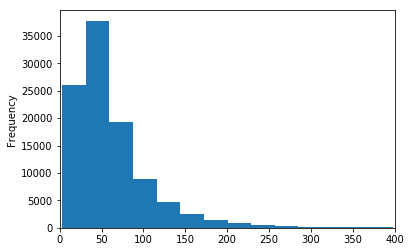

In [6]:
df['utterance_length'].plot(bins=50,kind='hist',xlim=(0,400))

In [7]:
# maps go old -> new
# 0:No Emotion; 1: anger; 2: disgust;\n 3: fear; 4: happiness; 5: sadness; 6: surprise'
# reclassify: 0: No emotion, 1: anger+disgust, 2:happy+surprise, 3:sad+fear
emote_mapping = {0:0,1:1,2:1,3:3,4:2,5:3,6:2}
df['emotion_remap'] = df['emotion'].map(emote_mapping)

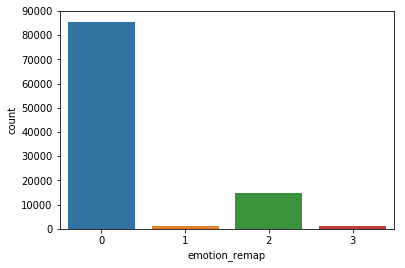

In [8]:
sns.countplot(df['emotion_remap'])

In [23]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer.fit(df['utterance'])

CountVectorizer(analyzer=<function text_process at 0x11f4590d0>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [28]:
utterance_bow = bow_transformer.transform(df['utterance'])

In [30]:
print ('Shape of Sparse Matrix: ', utterance_bow.shape)
print ('Amount of Non-Zero occurences: ', utterance_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * utterance_bow.nnz /
                             (utterance_bow.shape[0] * utterance_bow.shape[1])))

Shape of Sparse Matrix:  (102980, 26104)
Amount of Non-Zero occurences:  560461
sparsity: 0.02%


In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(utterance_bow)
utterance_tfidf = tfidf_transformer.transform(utterance_bow)

In [33]:
from sklearn.naive_bayes import MultinomialNB
emote_detect_model = MultinomialNB().fit(utterance_tfidf,df['emotion_remap'])

In [35]:
all_predictions = emote_detect_model.predict(utterance_tfidf)

In [37]:
from sklearn.metrics import classification_report
print (classification_report(df['emotion_remap'], all_predictions))

             precision    recall  f1-score   support

          0       0.85      0.99      0.92     85573
          1       0.00      0.00      0.00      1375
          2       0.80      0.14      0.24     14708
          3       0.00      0.00      0.00      1324

avg / total       0.82      0.85      0.80    102980



/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
from sklearn.pipeline import Pipeline

X = df['utterance']
y = df['emotion_remap']

y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipeline = Pipeline([('bow',CountVectorizer(analyzer=text_process)),
                    ('tfidf',TfidfTransformer()),
                    ('classifier',MultinomialNB())])
classifier = OneVsRestClassifier(pipeline)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

AttributeError: 'MultinomialNB' object has no attribute 'decision_function'

In [11]:
sid = SentimentIntensityAnalyzer()

In [12]:
vader_dict = [sid.polarity_scores(utt) for utt in df['utterance']]

In [17]:
df_vader = pd.DataFrame(vader_dict)
df_vader['utterance'] = df['utterance']
df_vader['emotion_remap'] = df['emotion_remap']

In [9]:
#df_vader.to_csv('../data/vaderd_utterances.csv')
df_vader = pd.read_csv('../data/vaderd_utterances.csv')

In [10]:
df_vader.head()

,Unnamed: 0,compound,neg,neu,pos,utterance,emotion_remap
0,0,-0.2500,0.50,0.500,0.000,The kitchen stinks .,1
1,1,0.0000,0.00,1.000,0.000,I'll throw out the garbage .,0
2,2,-0.5563,0.31,0.690,0.000,"So Dick , how about getting some coffee for to...",2
3,3,0.6705,0.00,0.522,0.478,Coffee ? I don ’ t honestly like that kind of...,1
4,4,0.0000,0.00,1.000,0.000,"Come on , you can at least try a little , bes...",0


In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import svm
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTEENN

X = df_vader[['compound', 'neg', 'neu', 'pos']]
y = df_vader['emotion_remap']
classes = ['No emotion','Angry','Happy','Sad']
ybin = label_binarize(y, classes=[0, 1, 2, 3])

print('Original dataset shape {}'.format(Counter(y)))

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X.values, y)

print('Random Undersampled dataset shape {}'.format(Counter(y_res)))

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X.values, y)

print('Random Oversampled dataset shape {}'.format(Counter(y_ros)))

#n_classes = ybin.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2)
#y_score = classifier.fit(X_train, y_train).decision_function(X_test)

Original dataset shape Counter({0: 85573, 2: 14708, 1: 1375, 3: 1324})
Random Undersampled dataset shape Counter({0: 1324, 1: 1324, 2: 1324, 3: 1324})
Random Oversampled dataset shape Counter({1: 85573, 0: 85573, 2: 85573, 3: 85573})


(0, 0.6)

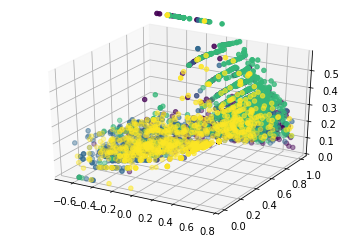

In [50]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_rus[:,0],X_rus[:,2],X_rus[:,3],c=y_rus)
ax.set_xlim(-0.75,0.8)
ax.set_zlim(0,0.6)

In [51]:
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(solver='saga')
#classifier = svm.SVC(C=20)
#classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
#clf.fit(X_train,y_train)

In [52]:
from sklearn.model_selection import GridSearchCV 
# GridSearchCV results:
# kernel='rbf', C=1e3, gamma=0.1
svc = svm.SVC(kernel='rbf',C=1e3,probability=True,gamma=0.1)
svc.fit(X_rus,y_rus)

SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
from sklearn.metrics import confusion_matrix
y_pred = svc.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [56]:
pickle.dump(svc,open("grid_optimized_emotion_SVM.pkl","wb"))

Confusion matrix, without normalization
[[ 9050   812  4737  2442]
 [ 6197  4714  1884  4306]
 [ 4682   497 10665  1560]
 [ 4378  3084  1305  8146]]
Normalized confusion matrix
[[0.53 0.05 0.28 0.14]
 [0.36 0.28 0.11 0.25]
 [0.27 0.03 0.61 0.09]
 [0.26 0.18 0.08 0.48]]


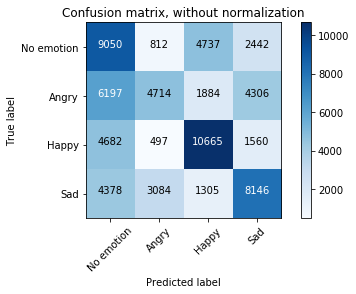

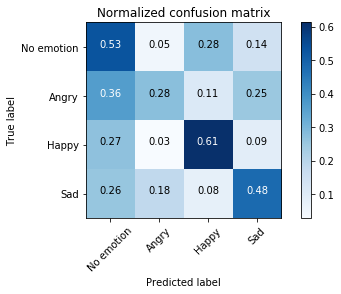

In [57]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,title='Normalized confusion matrix')

In [71]:
svc.predict_proba(X_test[:50])>0.75

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
 

In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

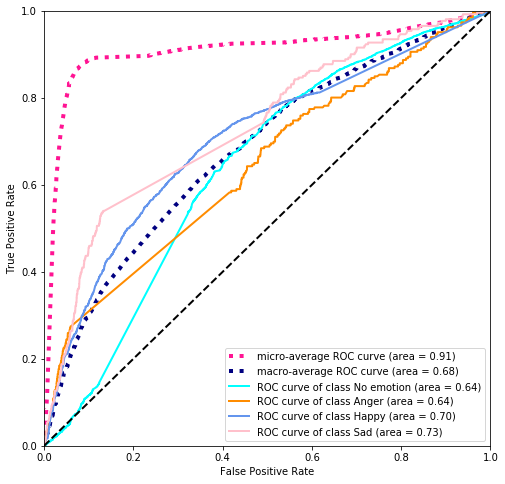

In [29]:
from itertools import cycle
lw =2 
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','pink'])
class_names = ['No emotion', 'Anger', 'Happy', 'Sad']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')